# **Wetland Monitoring and Alert System**

### **Step 1: Identify Key Health Indicators for Ajman's Wetlands**
  You need to measure what actually matters for a coastal wetland ecosystem in the UAE. Collaborate with local environmental experts or use established standards
  to focus on:
   * Core Water Quality:
       * Salinity: Crucial for coastal wetlands.
       * Dissolved Oxygen (DO): A primary indicator of water health and its ability to support life.
       * pH: Measures acidity or alkalinity.
       * Turbidity: Measures water clarity. High turbidity can block sunlight and harm aquatic plants.
       * Temperature: Directly affects metabolic rates and DO levels.
   * Nutrient/Pollutant Levels:
       * Nitrates and Phosphates: High levels can lead to eutrophication and algal blooms.
   * Ecological Indicators:
       * Chlorophyll-a: A proxy for algae concentration.
       * Presence/Abundance of Key Species: The number of flamingos, crabs, or specific types of fish can be a powerful bio-indicator of ecosystem health.

### **Step 2: Acquire the Data (The Hardest but Most Important Step)**
   * Option A (Ideal): Deploy IoT Sensors: For real-time data, deploy low-cost, solar-powered water quality sensors in the wetland. This gives you high-frequency
     data on temperature, pH, DO, and salinity.
   * Option B (Pragmatic): Partner with Local Authorities: Connect with the Ajman Municipality or UAE-level environmental agencies. They may already be collecting
     this data and could be valuable partners.
   * Option C (Advanced): Use Satellite Imagery: For monitoring larger areas, use satellite data (e.g., from Sentinel-2) to estimate turbidity, chlorophyll levels,
     and changes in water surface area over time.
   * Option D (Manual): Scheduled Manual Testing: If sensors are not feasible, start by collecting water samples on a regular schedule (e.g., weekly) and testing
     them with portable kits.

### **Step 3: Create the Master Dataset**
  Your goal is to create a single, unified dataset that links your existing inputs (weather, air quality) to these new, real-world measurements. The timestamp
  will be the key that connects everything.

  Phase 2: Build a Truly Predictive Model

  Now that you have real data, you can build a model that provides genuine insights.

  Step 1: Redefine Your Prediction Goal
  Instead of predicting a simulated score, set a meaningful, predictive target. For example:
   * Regression Task: "Forecast the Dissolved Oxygen level 24 hours in advance based on the weather forecast."
   * Classification Task: "Predict the probability of an algal bloom (high chlorophyll) in the next 3 days."

  Step 2: Evolve Your Model
  Your problem is now a time-series forecasting task. While Random Forest is a good start, consider more specialized models:
   * Gradient Boosting: XGBoost or LightGBM are often more powerful for tabular time-series data.
   * Deep Learning: LSTMs (Long Short-Term Memory networks) are excellent for learning complex patterns over time, especially if you have high-frequency sensor
     data.

  Phase 3: Develop an Actionable Alert System

  A model is only useful if it drives action.

  Step 1: Define Alert Thresholds
  Work with experts to set critical thresholds. For example, if the model predicts Dissolved Oxygen will drop below 4 mg/L, trigger an alert.

  Step 2: Build a Dashboard and Notification System
  Create a simple web dashboard (using tools like Streamlit or Dash) that visualizes:
   * Real-time sensor data.
   * The model's future predictions.
   * A clear "System Status" (e.g., Normal, Watch, Alert).

  When an alert is triggered, the system should automatically send a notification (e.g., an email or SMS) to the relevant stakeholders (like wetland managers or
  municipal authorities).

  Phase 4: Expand the Vision

  Step 1: Integrate Your Image Classifier
  Use your image-classifier.ipynb to build a model that can automatically identify and count key species like flamingos from camera traps or drone imagery. A
  sudden decline in their population is a powerful indicator of ecosystem distress. You can feed this data back into your main model.

  Step 2: Create a Feedback Loop
  Continuously monitor your model's accuracy. If it predicts an issue, and action is taken, record the outcome. This feedback is invaluable for retraining and
  improving the model over time.

# **Data Collection and Processing**

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Define time windows

time_windows = {
    "morning": (6, 12),   # 6:00 - 11:59
    "evening": (12, 18),  # 12:00 - 17:59
    "night":   (18, 24)   # 18:00 - 23:59
}

# 1. Fetch Weather Data (Open-Meteo)

def fetch_weather_simple(lat=25.4052, lon=55.5136, days=3):
    start = datetime.utcnow().date() - timedelta(days=days-1)
    end = datetime.utcnow().date()
    
    url = (
        f"https://api.open-meteo.com/v1/forecast?"
        f"latitude={lat}&longitude={lon}&hourly=temperature_2m,relative_humidity_2m,cloudcover,windspeed_10m"
        f"&start={start}&end={end}&timezone=GMT"
    )
    response = requests.get(url).json()
    
    df = pd.DataFrame(response.get("hourly", {}))
    if df.empty or "time" not in df.columns:
        return pd.DataFrame()
    
    df["timestamp"] = pd.to_datetime(df["time"])
    df = df.drop(columns=["time"])
    
    # Assign coarse time windows
    df["hour"] = df["timestamp"].dt.hour
    df["time_window"] = df["hour"].apply(lambda h: next((tw for tw, (start, end) in time_windows.items() if start <= h < end), "night"))
    
    # Aggregate by day + time_window
    df["date"] = df["timestamp"].dt.date
    agg_df = df.groupby(["date", "time_window"]).mean().reset_index()
    return agg_df

# 2. Fetch AQI Data (OpenAQ) and average by day

def fetch_aqi_simple(city="Ajman", days=3, limit=100):
    url = f"https://api.openaq.org/v2/latest?city={city}&limit={limit}"
    response = requests.get(url).json()
    
    data = []
    for result in response.get("results", []):
        measurements = {m["parameter"]: m["value"] for m in result.get("measurements", [])}
        timestamp = result.get("measurements")[0]["lastUpdated"] if result.get("measurements") else None
        if timestamp:
            data.append({
                "location": result.get("location"),
                "AQI_PM2_5": measurements.get("pm25"),
                "AQI_PM10": measurements.get("pm10"),
                "AQI_NO2": measurements.get("no2"),
                "AQI_O3": measurements.get("o3"),
                "timestamp": pd.to_datetime(timestamp)
            })
    df = pd.DataFrame(data)
    if df.empty:
        return pd.DataFrame()
    
    df["date"] = df["timestamp"].dt.date
    df["hour"] = df["timestamp"].dt.hour
    df["time_window"] = df["hour"].apply(lambda h: next((tw for tw, (start, end) in time_windows.items() if start <= h < end), "night"))
    
    agg_df = df.groupby(["date", "time_window"]).mean().reset_index()
    return agg_df

# 3. Combine Weather + AQI

weather_df = fetch_weather_simple()
aqi_df = fetch_aqi_simple()

if not weather_df.empty and not aqi_df.empty:
    combined_df = pd.merge(weather_df, aqi_df, on=["date", "time_window"], how="outer")
else:
    combined_df = weather_df if not weather_df.empty else aqi_df

print(combined_df.head())


/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_48679/1028467765.py:18: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start = datetime.utcnow().date() - timedelta(days=days-1)
/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_48679/1028467765.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = datetime.utcnow().date()


         date time_window  temperature_2m  relative_humidity_2m  cloudcover  \
0  2025-11-10     evening       27.983333             55.333333    3.833333   
1  2025-11-10     morning       27.083333             60.333333   93.666667   
2  2025-11-10       night       27.583333             55.833333   57.916667   
3  2025-11-11     evening       28.433333             52.500000    0.333333   
4  2025-11-11     morning       27.433333             56.333333    0.000000   

   windspeed_10m           timestamp  hour  
0      13.616667 2025-11-10 14:30:00  14.5  
1       7.200000 2025-11-10 08:30:00   8.5  
2       7.141667 2025-11-10 11:30:00  11.5  
3      15.733333 2025-11-11 14:30:00  14.5  
4       8.183333 2025-11-11 08:30:00   8.5  


## **Water Quality Index (WQI) Prediction**

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Simulate WQI (handles missing columns & simulates the ecosystem)
def simulate_wqi(df):
    # Normalize pollutants if available, else default 0
    pm25_norm = df['AQI_PM2_5'] / 100 if 'AQI_PM2_5' in df else 0
    pm10_norm = df['AQI_PM10'] / 200 if 'AQI_PM10' in df else 0
    no2_norm  = df['AQI_NO2'] / 50 if 'AQI_NO2' in df else 0
    
    # Temperature penalty (ideal 20-25°C)
    temp_penalty = np.abs(df['temperature_2m'] - 22.5)/10 if 'temperature_2m' in df else 0
    
    # Combine factors (weights can be tuned)
    pollution_score = 0.4*pm25_norm + 0.3*pm10_norm + 0.3*no2_norm
    total_penalty = pollution_score + temp_penalty
    wqi = 100 * (1 - np.clip(total_penalty, 0, 1))
    return wqi

# 2. Preprocess Dataset

if not combined_df.empty:
    
    # Ensure all columns exist
    for col in ['AQI_PM2_5', 'AQI_PM10', 'AQI_NO2', 'temperature_2m', 
                'relative_humidity_2m', 'cloudcover', 'windspeed_10m']:
        if col not in combined_df.columns:
            combined_df[col] = 0
    
    # Interpolate missing values
    combined_df.interpolate(method='linear', limit_direction='forward', inplace=True)
    combined_df.fillna(method='bfill', inplace=True)
    
    # Simulate WQI
    combined_df['WQI'] = simulate_wqi(combined_df)
    
    # Features and target
    features = ['temperature_2m', 'relative_humidity_2m', 'cloudcover', 
                'windspeed_10m', 'AQI_PM2_5', 'AQI_PM10', 'AQI_NO2']
    target = 'WQI'
    
    model_df = combined_df[features + [target]].dropna()
    X = model_df[features]
    y = model_df[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 3. Train and Evaluate Models
    
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=42)
    }
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f'--- {name} ---')
        mae = mean_absolute_error(y_test, y_pred)
        print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')
    
    # 4. Display Sample Predictions

    predictions_df = pd.DataFrame({
        'Actual WQI': y_test,
        'Predicted WQI': models['Random Forest'].predict(X_test_scaled)
    }).reset_index(drop=True)
    print("--- Sample Predictions ---")
    print(predictions_df.head())
    
else:
    print("Combined dataframe is empty. Cannot proceed with modeling.")


--- Linear Regression ---
RMSE: 0.0000, MAE: 0.0000
--- Random Forest ---
RMSE: 1.2572, MAE: 1.1188
--- Sample Predictions ---
   Actual WQI  Predicted WQI
0   45.166667      46.635000
1   60.750000      60.124167
2   46.166667      45.736667
3   54.166667      56.180000
4   61.416667      60.360000


/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_48679/1196301714.py:36: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df.interpolate(method='linear', limit_direction='forward', inplace=True)
/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_48679/1196301714.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df.fillna(method='bfill', inplace=True)


## **Exploratory Data Analysis (EDA)**

In [ ]:
# Combines numerical statitsics

if not combined_df.empty:
    print("--- Descriptive Statistics ---")
    print(combined_df.describe())
else:
    print("Combined dataframe is empty.")

--- Descriptive Statistics ---
       temperature_2m  relative_humidity_2m  cloudcover  windspeed_10m  \
count       21.000000             21.000000   21.000000      21.000000   
mean        27.355556             56.650794   11.492063      10.263095   
min         26.108333             39.833333    0.000000       6.866667   
25%         26.816667             52.500000    0.000000       7.383333   
50%         27.433333             56.333333    0.000000       8.633333   
75%         27.900000             60.333333    6.500000      13.616667   
max         28.716667             67.666667   93.666667      17.783333   
std          0.783410              6.502917   23.646689       3.463831   

                           timestamp      hour  AQI_PM2_5  AQI_PM10  AQI_NO2  \
count                             21  21.00000       21.0      21.0     21.0   
mean   2025-11-13 11:30:00.000000256  11.50000        0.0       0.0      0.0   
min              2025-11-10 08:30:00   8.50000        0.0     

## **Data Visualization**

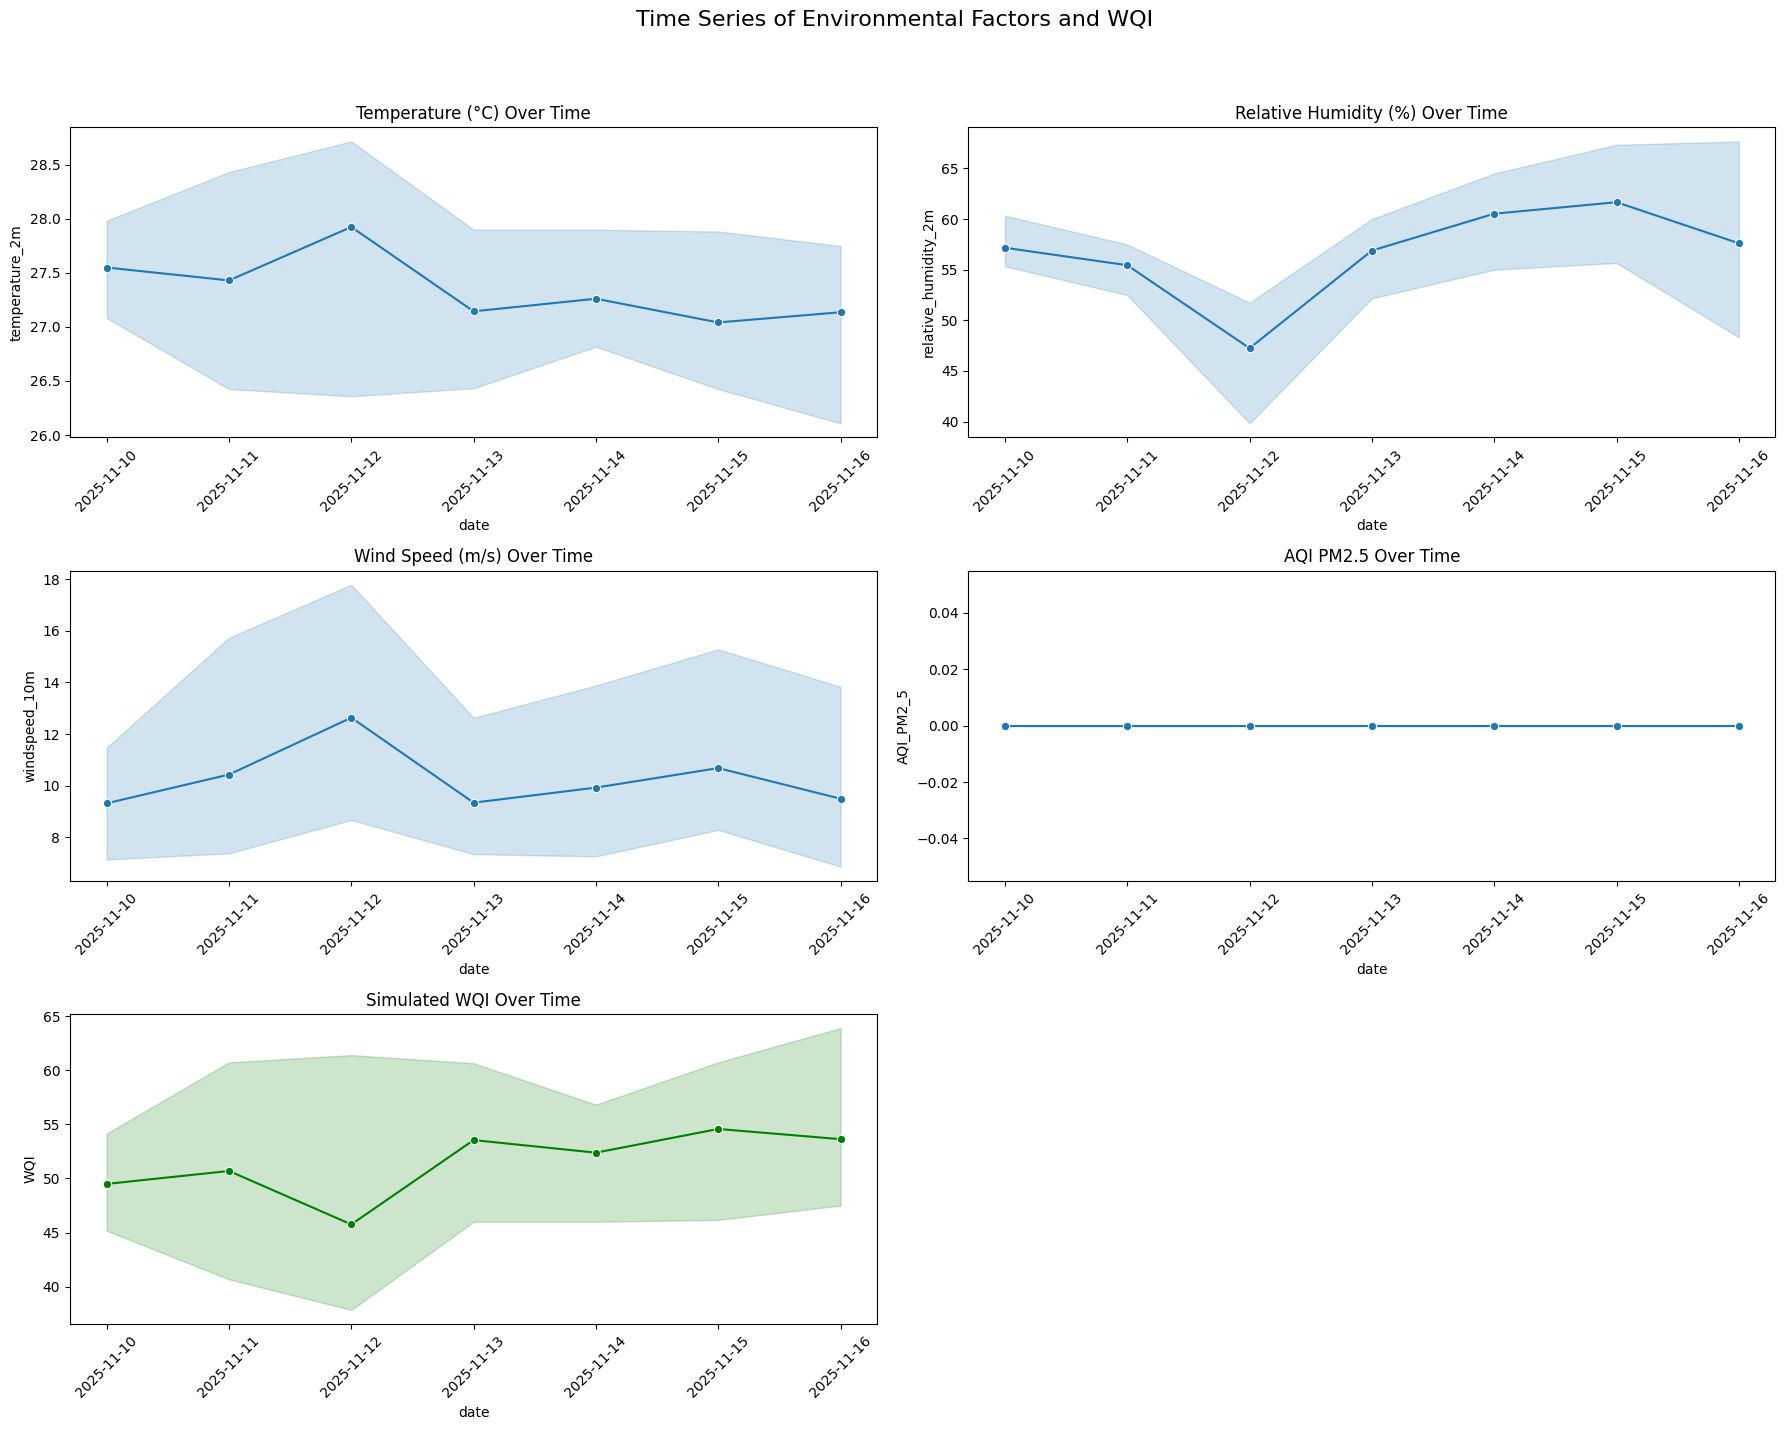

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

if not combined_df.empty:
    # Convert 'date' to datetime for plotting
    plot_df = combined_df.copy()
    plot_df['date'] = pd.to_datetime(plot_df['date'])
    plot_df = plot_df.sort_values('date')
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    fig.suptitle('Time Series of Environmental Factors and WQI', fontsize=16)
    
    # Temperature
    sns.lineplot(ax=axes[0, 0], data=plot_df, x='date', y='temperature_2m', marker='o')
    axes[0, 0].set_title('Temperature (°C) Over Time')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Humidity
    sns.lineplot(ax=axes[0, 1], data=plot_df, x='date', y='relative_humidity_2m', marker='o')
    axes[0, 1].set_title('Relative Humidity (%) Over Time')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Wind Speed
    sns.lineplot(ax=axes[1, 0], data=plot_df, x='date', y='windspeed_10m', marker='o')
    axes[1, 0].set_title('Wind Speed (m/s) Over Time')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # AQI PM2.5
    sns.lineplot(ax=axes[1, 1], data=plot_df, x='date', y='AQI_PM2_5', marker='o')
    axes[1, 1].set_title('AQI PM2.5 Over Time')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Simulated WQI
    sns.lineplot(ax=axes[2, 0], data=plot_df, x='date', y='WQI', marker='o', color='g')
    axes[2, 0].set_title('Simulated WQI Over Time')
    axes[2, 0].tick_params(axis='x', rotation=45)
    
    # Hide empty subplot
    fig.delaxes(axes[2,1])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Combined dataframe is empty. Cannot create plots.")

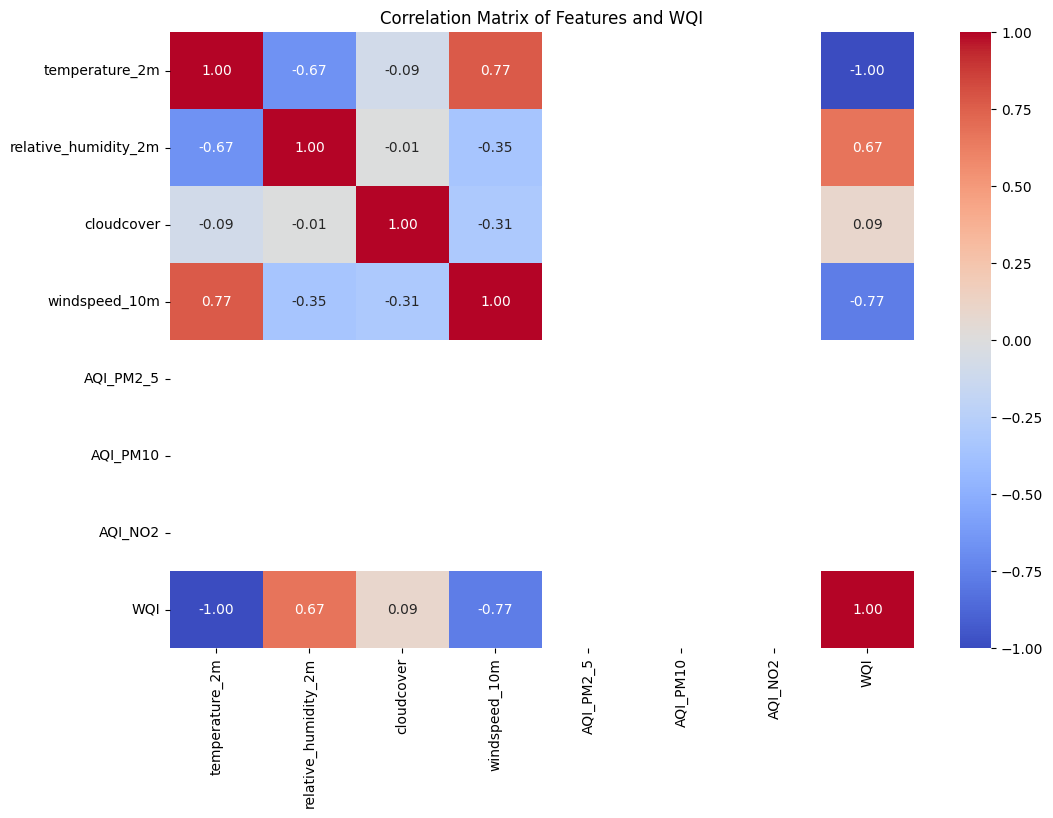

In [6]:
if not combined_df.empty:
    plt.figure(figsize=(12, 8))
    correlation_matrix = model_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Features and WQI')
    plt.show()
else:
    print("Combined dataframe is empty. Cannot create heatmap.")

## **Model Performance Visualization**

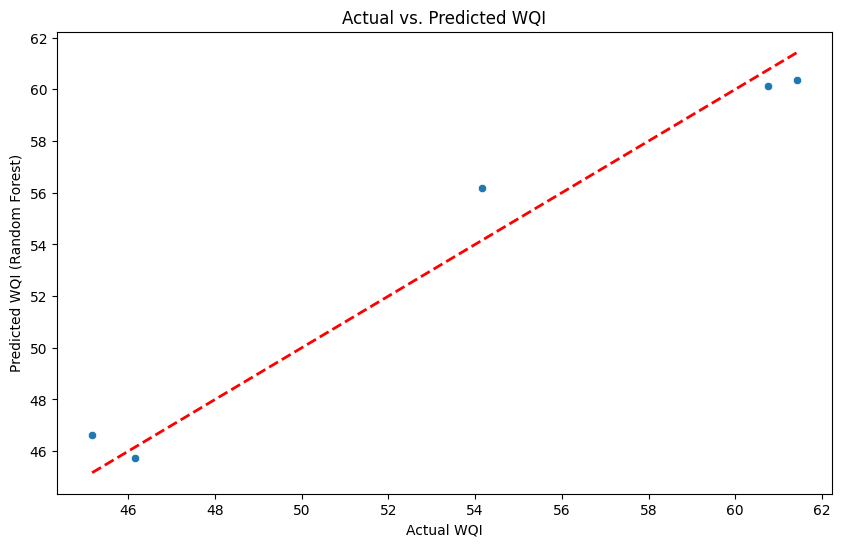

In [7]:
if 'y_test' in locals() and 'models' in locals():
    y_pred_rf = models['Random Forest'].predict(X_test_scaled)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred_rf)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel('Actual WQI')
    plt.ylabel('Predicted WQI (Random Forest)')
    plt.title('Actual vs. Predicted WQI')
    plt.show()
else:
    print("Model has not been trained. Cannot visualize performance.")

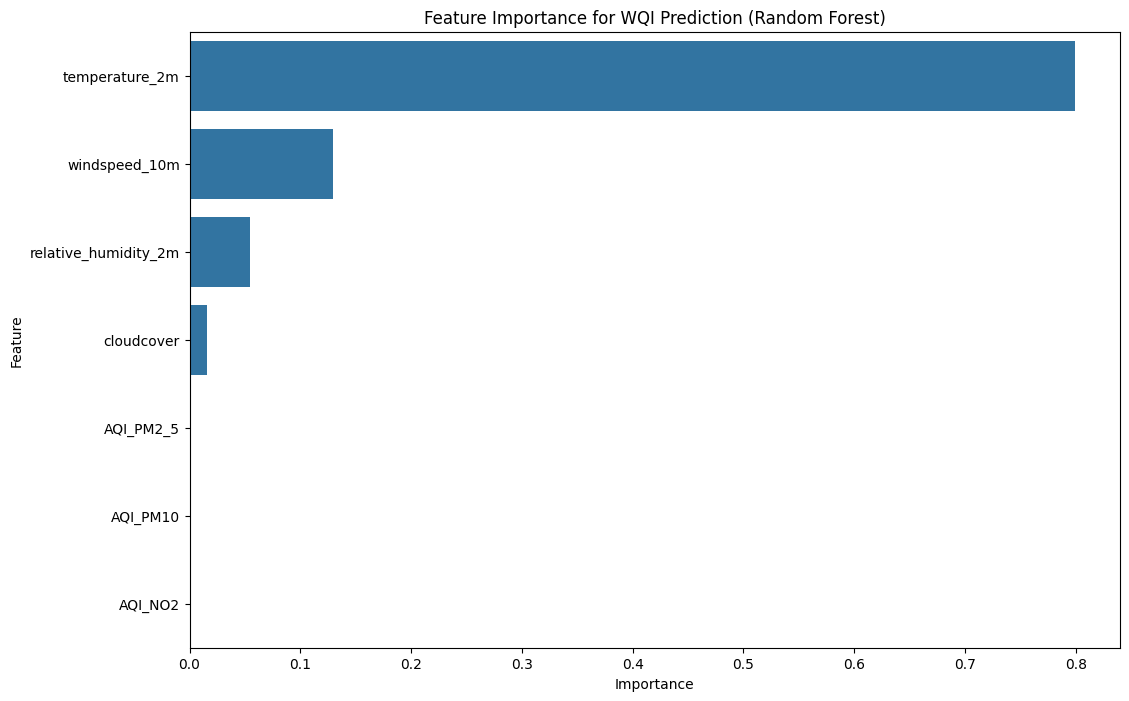

In [8]:
if 'models' in locals() and 'features' in locals():
    feature_importances = models['Random Forest'].feature_importances_
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for WQI Prediction (Random Forest)')
    plt.show()
else:
    print("Model has not been trained. Cannot show feature importances.")